In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense

from sklearn.preprocessing import MinMaxScaler

In [19]:
garlic = pd.read_csv("plz.csv",encoding='euc=kr')
garlic


,시군산지,연도,월,시점,일자,품목,품종,광역산지,도매가격.원.kg.,거래량.톤.,거래금액.백만원.,마늘.면적..ha.,X10a당.생산량..kg.,생산량..톤.,X10a당.생산량.톤,평균,평균기온..C.,평균상대습도...,월합강수량.00.24h만..mm.,합계.일조시간.hr.
0,강릉,2016,3,2016,2016-07-02,마늘,햇마늘 한지,강원,2500,0.040,0.10,180,807,1452,0.807,0.040000,7.9,49,29.3,207.0
1,강릉,2017,10,2018,2018-01-30,마늘,풋마늘,강원,6900,0.030,0.19,265,754,1999,0.754,0.052314,15.2,67,114.5,152.6
2,강릉,2017,10,2018,2018-01-16,마늘,깐마늘,강원,7573,0.030,0.23,265,754,1999,0.754,0.052314,15.2,67,114.5,152.6
3,강릉,2017,10,2018,2018-02-07,마늘,깐마늘,강원,6400,0.002,0.01,265,754,1999,0.754,0.052314,15.2,67,114.5,152.6
4,강릉,2017,10,2018,2018-01-16,마늘,풋마늘,강원,6906,0.020,0.12,265,754,1999,0.754,0.052314,15.2,67,114.5,152.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,홍천,2020,4,2020,2020-07-30,마늘,깐마늘,강원,5250,2.000,10.50,236,1049,2476,1.049,1.758178,10.1,51,14.2,254.3
1447,홍천,2020,4,2020,2020-07-14,마늘,깐마늘,강원,5250,1.000,5.25,236,1049,2476,1.049,1.758178,10.1,51,14.2,254.3
1448,홍천,2020,5,2020,2020-08-12,마늘,깐마늘,강원,5250,2.000,10.50,236,1049,2476,1.049,1.758178,17.2,70,105.0,185.1
1449,홍천,2020,7,2020,2020-10-29,마늘,풋마늘,강원,2808,0.030,0.07,236,1049,2476,1.049,1.758178,22.8,78,213.9,130.0


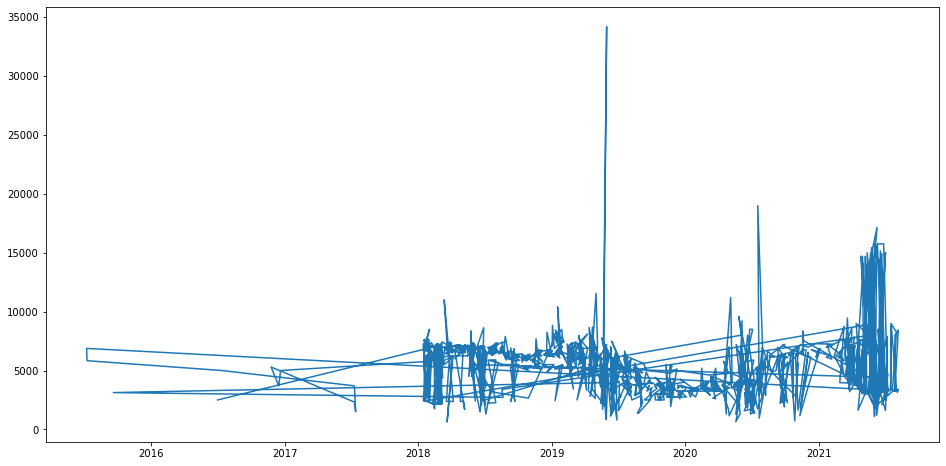

In [20]:
garlic["일자"]=pd.to_datetime(garlic['일자'],format="%Y-%m-%d")
garlic.index=garlic['일자']
plt.figure(figsize=(16,8))
plt.plot(garlic["도매가격.원.kg."],label='Close Price history')

In [22]:
data=garlic.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(garlic)),columns=['일자','도매가격.원.kg.'])

for i in range(0,len(data)):
    new_dataset["일자"][i]=data['일자'][i]
    new_dataset["도매가격.원.kg."][i]=data["도매가격.원.kg."][i]

In [23]:
# 2019년12월12일의 데이터까지 데이터를 훈련시킨다.  
# 배추의 2019년 데이터는 12/12 일까지만 존재함.

scaler=MinMaxScaler(feature_range=(0,1))
new_dataset.index=new_dataset['일자']
new_dataset.drop("일자",axis=1,inplace=True)
final_dataset=new_dataset.values

train_data=final_dataset[0:545,:]
valid_data=final_dataset[545:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [24]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

485/485 - 13s - loss: 0.0021


In [25]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_price=lstm_model.predict(X_test)
predicted_price=scaler.inverse_transform(predicted_price)

In [26]:
lstm_model.save("saved_model.h5")


<ipython-input-28-10885a8e665d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_price


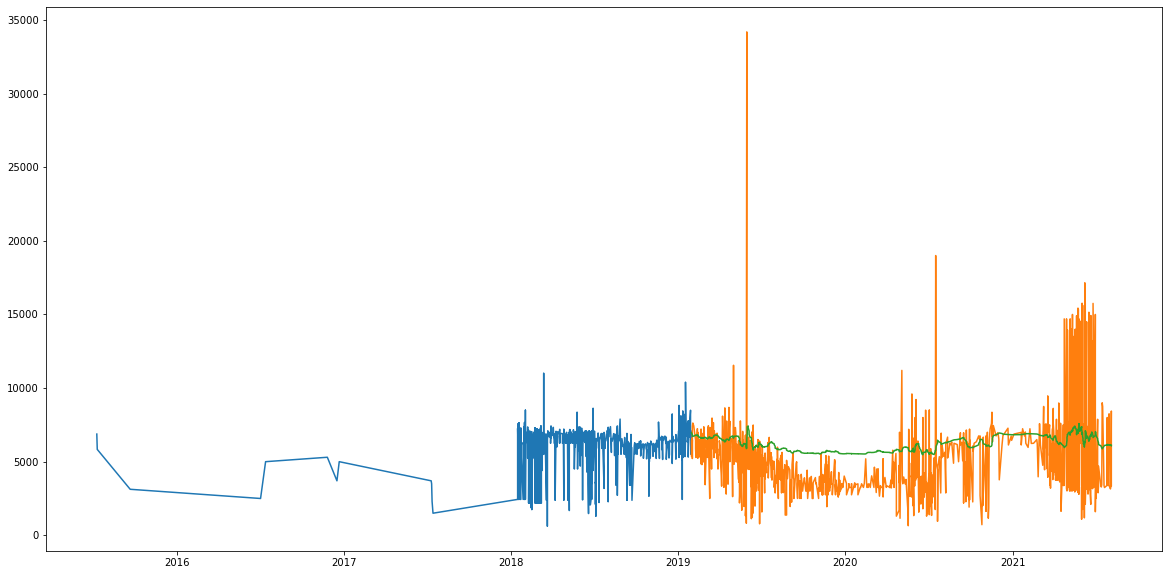

In [28]:
train_data=new_dataset[:545]
valid_data=new_dataset[545:]
valid_data['Predictions']=predicted_price
plt.plot(train_data["도매가격.원.kg."])
plt.plot(valid_data[['도매가격.원.kg.',"Predictions"]])